# Predicting Churn

## Get the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.utils import to_categorical
from keras import models
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Activation
from keras import regularizers

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

import seaborn as sns
# This one is rare, and will require pip install pycountry-convert
from pycountry_convert import country_alpha2_to_continent_code 

/Users/zoekoch/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/zoekoch/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Load the data
df = pd.read_csv('exercise-data.csv', encoding = "ISO-8859-1")
print(df.head())
print(df.describe())

   SubscriberKey               EmailDomain AccountCreatedDate ProductType  \
0              5  social-media-productions           10/10/13         STD   
1             13                   hotmail            4/16/10        PLUS   
2             28                   hotmail             9/6/12         STD   
3             51                     gmail            12/8/13         STD   
4             56                      live            7/11/13        PLUS   

   BilledAmount StartDate  EndDate BeginningState EndingState  TenureMonth  \
0         29.00   4/17/15  5/17/15        Renewal     Renewed           19   
1         16.81   6/30/15   8/1/15   Reactivation     Renewed           64   
2         29.00   4/28/15  5/28/15        Renewal     Renewed           33   
3         29.00   5/11/15  6/11/15        Renewal     Renewed           18   
4         49.00   8/23/15  9/23/15        Renewal     Renewed           26   

           ...          PercOfflineView DaysSinceLastLogin  ViewMinP

In [3]:
# 5 variables have missing values.
print(df.isnull().sum())

SubscriberKey                    0
EmailDomain                      0
AccountCreatedDate               0
ProductType                      0
BilledAmount                     0
StartDate                        0
EndDate                          0
BeginningState                   0
EndingState                      0
TenureMonth                      0
Channel                       8530
AutoRenewOn                    183
NActiveMonths                    0
NContinuousActiveMonths          0
MaxContinuousActiveMonths        0
CountryCode                     29
Company                      23829
StartTrial                       0
NPrevChurns                      0
TurnAutoRenewOff                 0
PercActiveDay                    0
PercOfflineView                  0
DaysSinceLastLogin             633
ViewMinPerDay                    0
ViewMinPerActiveDay              0
ClipsPerDay                      0
ClipsPerActiveDay                0
NCoursesPerDay                   0
CourseCompletionRate

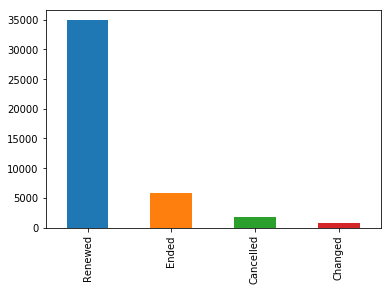

In [4]:
# The variables we're predicting, EndingState, is quite unbalanced.
fig, ax = plt.subplots()
df['EndingState'].value_counts().plot(ax=ax, kind='bar')
plt.show() 

## Data Cleaning

In [6]:
# Format dates

# Convert the date variables to a form pandas recognizes as a date, 
# then transformed into a numeric variable the classifier can read.
df.AccountCreatedDate = pd.to_numeric(pd.to_datetime(df.AccountCreatedDate),downcast='float')
df.StartDate = pd.to_numeric(pd.to_datetime(df.StartDate),downcast='float')
df.EndDate = pd.to_numeric(pd.to_datetime(df.EndDate),downcast='float')

In [7]:
# Adjust DaysSinceLastLogin

# Some of the DaysSinceLastLogin variables look like they were mislabeled as negative numbers.
# There are only 4 such observations, and they look like they're missing 
# other values, too. We'll need to remove them from the data set.
print(df[df.DaysSinceLastLogin < 0])
df = df[df.DaysSinceLastLogin >= 0]

# To handle the missing values on this continuous variable, we'll fill the missing 
# values with an estimation of the value--the median.
df.DaysSinceLastLogin = df.DaysSinceLastLogin.fillna(df.DaysSinceLastLogin.median())

       SubscriberKey EmailDomain  AccountCreatedDate ProductType  \
36634         446266       gmail        1.428192e+18        PLUS   
39314         464974       gmail        1.432166e+18        PLUS   
41390         479535       gmail        1.435363e+18         STD   
42547         488130         mac        1.437437e+18         STD   

       BilledAmount     StartDate       EndDate BeginningState EndingState  \
36634          29.0  1.430438e+18  1.430870e+18         Change     Renewed   
39314           7.1  1.433117e+18  1.433981e+18         Change   Cancelled   
41390          29.0  1.438042e+18  1.438387e+18        Renewal     Changed   
42547          29.0  1.438387e+18  1.438387e+18     Conversion       Ended   

       TenureMonth      ...      PercOfflineView DaysSinceLastLogin  \
36634            1      ...                  0.0               -8.0   
39314            1      ...                  0.0               -3.0   
41390            2      ...                  0.0       

In [8]:
# Convert CountryCode to ContinentCode

# Under ISO 3166-1 alpha-2 codes, UK should be GB
df.CountryCode = df.CountryCode.replace('UK', 'GB')
# TL is Timor-Leste, a southeast asian country so small the country-to-continent converter doesn't recognize it. 
# We'll rename it a neighboring country, Indonesia, so that it's converted to the appropriate continent.
df.CountryCode = df.CountryCode.replace('TL', 'ID')
# Convert from country code to continent. Leave the non-string values untouched.
df.CountryCode = df.CountryCode.apply(lambda x: country_alpha2_to_continent_code(x) 
                                                if type(x)==str 
                                                else x)
df.rename(index=str, columns={"CountryCode": "ContinentCode"})

,SubscriberKey,EmailDomain,AccountCreatedDate,ProductType,BilledAmount,StartDate,EndDate,BeginningState,EndingState,TenureMonth,...,PercOfflineView,DaysSinceLastLogin,ViewMinPerDay,ViewMinPerActiveDay,ClipsPerDay,ClipsPerActiveDay,NCoursesPerDay,CourseCompletionRate,MaxCourseCompletionRate,CoursePillar
0,5,social-media-productions,1.381363e+18,STD,29.00,1.429229e+18,1.431821e+18,Renewal,Renewed,19,...,0.000000,13.0,10.737255,60.844444,6.941176,39.333333,0.176471,0.212801,0.419307,Software Development
1,13,hotmail,1.271376e+18,PLUS,16.81,1.435622e+18,1.438387e+18,Reactivation,Renewed,64,...,0.000000,3.0,10.529825,22.229630,3.368421,7.111111,0.157895,0.190862,0.404102,Software Development
2,28,hotmail,1.346890e+18,STD,29.00,1.430179e+18,1.432771e+18,Renewal,Renewed,33,...,0.000000,29.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,None
3,51,gmail,1.386461e+18,STD,29.00,1.431302e+18,1.433981e+18,Renewal,Renewed,18,...,0.000000,11.0,1.068519,19.233333,0.277778,5.000000,0.055556,0.116957,0.116957,Software Development
4,56,live,1.373501e+18,PLUS,49.00,1.440288e+18,1.442966e+18,Renewal,Renewed,26,...,0.000000,2.0,1.725926,31.066667,0.333333,6.000000,0.055556,0.139678,0.139678,IT Pro
5,74,boldit,1.348445e+18,PLUS,49.00,1.418515e+18,1.421194e+18,Renewal,Renewed,28,...,0.000000,2.0,2.574074,23.166667,0.555556,5.000000,0.055556,0.034378,0.034378,Software Development
6,85,yahoo,1.377043e+18,PLUS,49.00,1.427414e+18,1.430093e+18,Renewal,Renewed,20,...,0.000000,0.0,60.700926,72.841111,24.500000,29.400000,1.444444,0.305035,0.998736,Software Development
7,91,rogers,1.374883e+18,STD,29.00,1.431389e+18,1.434067e+18,Renewal,Renewed,22,...,0.000000,1.0,2.494444,22.450000,0.500000,4.500000,0.111111,0.065013,0.097854,IT Pro
8,92,yahoo,1.338854e+18,STD,29.00,1.430784e+18,1.433462e+18,Renewal,Renewed,36,...,0.000000,185.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,None
9,125,gmail,1.380154e+18,STD,29.00,1.430784e+18,1.433462e+18,Renewal,Renewed,20,...,0.000000,8.0,9.474074,56.844444,3.277778,19.666667,0.166667,0.438890,0.994444,Software Development


In [9]:
# Format Company

# The Company variable is a good candidate for feature embedding, but that's beyond the scope of this project.
# We'll turn it into a binary of whether or not company was reported.
df.Company = df.Company.isnull().astype(int)

In [10]:
# The remaining missing variables are labeled "Null".
df = df.fillna("Null")

In [11]:
# Format EmailDomain

# Group the EmailDomain variable into 6 categories to make it more manageable. 
df.EmailDomain = df.EmailDomain.str.lower()
print(df['EmailDomain'].value_counts())
# All EmailDomains that aren't in the top 5 will be "other"

df.EmailDomain = df.EmailDomain.apply(lambda x: 'other' 
                                                if x not in ["gmail", "hotmail", "yahoo", "outlook", "live","Null"]
                                                else x)
df.EmailDomain

gmail                  16750
hotmail                 3504
yahoo                   2808
outlook                 1045
live                     695
comcast                  321
msn                      283
me                       234
aol                      169
us                       155
googlemail               125
icloud                   117
verizon                  102
microsoft                 90
gmx                       84
cox                       78
mail                      71
mac                       68
att                       64
skylinetechnologies       63
btinternet                63
sbcglobal                 58
bellsouth                 50
ymail                     43
charter                   40
shaw                      34
earthlink                 32
rocketmail                25
buchanan                  25
rogers                    24
                       ...  
shafiee                    1
dyz                        1
tonyfrenchsystems          1
reso-tech     

0          other
1        hotmail
2        hotmail
3          gmail
4           live
5          other
6          yahoo
7          other
8          yahoo
9          gmail
10         gmail
11         other
12         other
13         other
14         gmail
15         other
16         yahoo
17         other
18         other
19         gmail
20         other
21         other
22         other
23         gmail
24         other
25         gmail
26         gmail
27         gmail
28         other
29         gmail
          ...   
43110    outlook
43111      gmail
43112      gmail
43114      other
43116    hotmail
43117    hotmail
43118      gmail
43119      gmail
43120      gmail
43121      gmail
43122      other
43123      gmail
43124      gmail
43125      gmail
43126      other
43127      gmail
43128      other
43129      other
43130      other
43131      gmail
43132      gmail
43133      gmail
43134      gmail
43135      gmail
43136      other
43137      gmail
43138      gmail
43139      oth

In [12]:
# Create the churn variable that we're predicting.
df['Churn'] = df.EndingState.replace(['Renewed', 'Changed','Ended','Cancelled'], [0, 0, 1, 1])

## Data Preprocessing

In [13]:
# x is all our variables except what we're predicting.
x = df[df.columns.difference(['EndingState', 'Churn'])]

# Make the categorical variables one-hot.
x = pd.get_dummies(x)
feature_list = list(x.columns)
print("Feature names: %s" % (feature_list))
x = x.values
print("%d observations, %d features" % (x.shape))

# Set the dependent variable.
y = df['Churn'].values

# Split the dataset into train and test groups.
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size = 0.2, random_state = 2)

Feature names: ['AccountCreatedDate', 'BilledAmount', 'ClipsPerActiveDay', 'ClipsPerDay', 'Company', 'CourseCompletionRate', 'DaysSinceLastLogin', 'EndDate', 'MaxContinuousActiveMonths', 'MaxCourseCompletionRate', 'NActiveMonths', 'NContinuousActiveMonths', 'NCoursesPerDay', 'NPrevChurns', 'PercActiveDay', 'PercOfflineView', 'StartDate', 'StartTrial', 'SubscriberKey', 'TenureMonth', 'TurnAutoRenewOff', 'ViewMinPerActiveDay', 'ViewMinPerDay', 'AutoRenewOn_Null', 'AutoRenewOn_no', 'AutoRenewOn_yes', 'BeginningState_Change', 'BeginningState_Conversion', 'BeginningState_Direct', 'BeginningState_Reactivation', 'BeginningState_Renewal', 'Channel_(Other)', 'Channel_Affiliates', 'Channel_Direct', 'Channel_Display', 'Channel_Email', 'Channel_Null', 'Channel_Organic Search', 'Channel_Paid Search', 'Channel_Referral', 'Channel_Social', 'CountryCode_AF', 'CountryCode_AS', 'CountryCode_EU', 'CountryCode_NA', 'CountryCode_Null', 'CountryCode_OC', 'CountryCode_SA', 'CoursePillar_Creative', 'CoursePil

## Build a Random Forest

In [14]:
# Build and train the forest
random_forest = RandomForestClassifier(n_estimators=10, max_depth = 4)
random_forest.fit(x_train, y_train)

# Train and Test Accuracy
y_predict_train = random_forest.predict(x_train)
y_predict_test = random_forest.predict(x_test)

print("Train accuracy : ", accuracy_score(y_train, y_predict_train) )
print("Test accuracy  : ", accuracy_score(y_test, y_predict_test))

prf = precision_recall_fscore_support(y_test, y_predict_test, average='macro')
print("Precision : ", prf[0])
print("Recall : ", prf[1])

conf_mat = confusion_matrix(y_test, y_predict_test)

Train accuracy :  0.8938654275967534
Test accuracy  :  0.8970709328314316
Precision :  0.8871828980755689
Recall :  0.7221631634644132


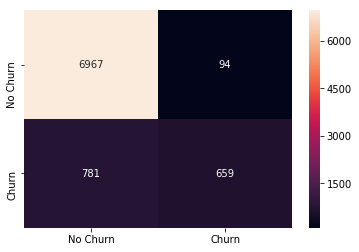

In [15]:
# See the confusion matrix
y_labels = ['No Churn','Churn']
df_cm = pd.DataFrame(conf_mat, index = y_labels,
                  columns = y_labels)
sns.heatmap(df_cm, annot=True, fmt='g')

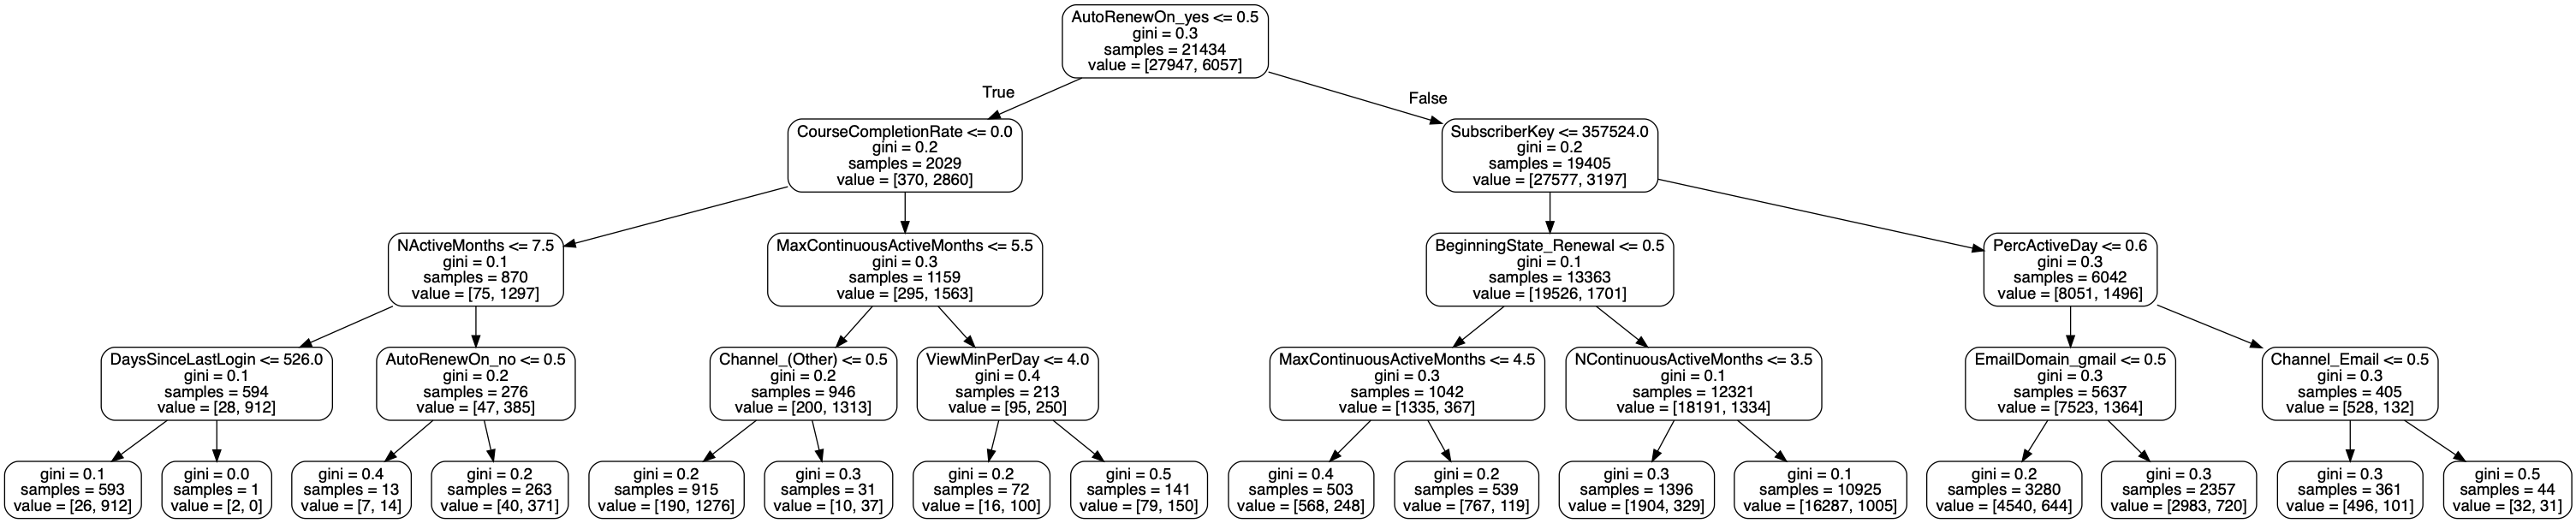

In [16]:
# Visualize the tree
# Pull out one tree from the forest
tree = random_forest.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')
# Display in the notebook
Image(filename = 'tree.png')

## Try an AdaBoost model

In [17]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=6)

adaboost.fit(x_train, y_train)

# Train and Test Accuracy
y_predict_train = adaboost.predict(x_train)
y_predict_test = adaboost.predict(x_test)

print("Train accuracy : ", accuracy_score(y_train, y_predict_train) )
print("Test accuracy  : ", accuracy_score(y_test, y_predict_test))
prf = precision_recall_fscore_support(y_test, y_predict_test, average='macro')
print("Precision : ", prf[0])
print("Recall : ", prf[1])

conf_mat = confusion_matrix(y_test, y_predict_test)

Train accuracy :  0.8950711680978708
Test accuracy  :  0.8974238324902952
Precision :  0.8816213475152923
Recall :  0.7270745802451651


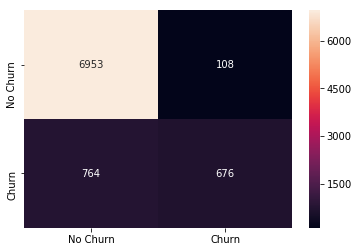

In [18]:
# See the confusion matrix
y_labels = ['No Churn','Churn']
df_cm = pd.DataFrame(conf_mat, index = y_labels,
                  columns = y_labels)
sns.heatmap(df_cm, annot=True, fmt='g')

## Interpret features

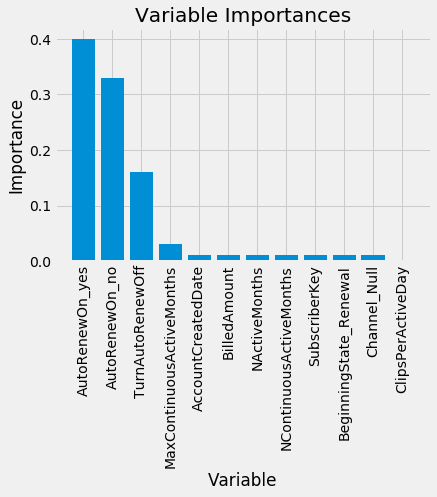

In [19]:
# Get numerical feature importances, sorted from most to least important
importances = list(random_forest.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances.sort(reverse=True, key=lambda tup: tup[1])
sorted_features = [x[0] for x in feature_importances[:12]]
sorted_importances = [x[1] for x in feature_importances[:12]]

# Plot results
plt.style.use('fivethirtyeight')
x_values = list(range(len(sorted_importances)))
plt.bar(x_values, sorted_importances, orientation = 'vertical')
plt.xticks(x_values, sorted_features, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

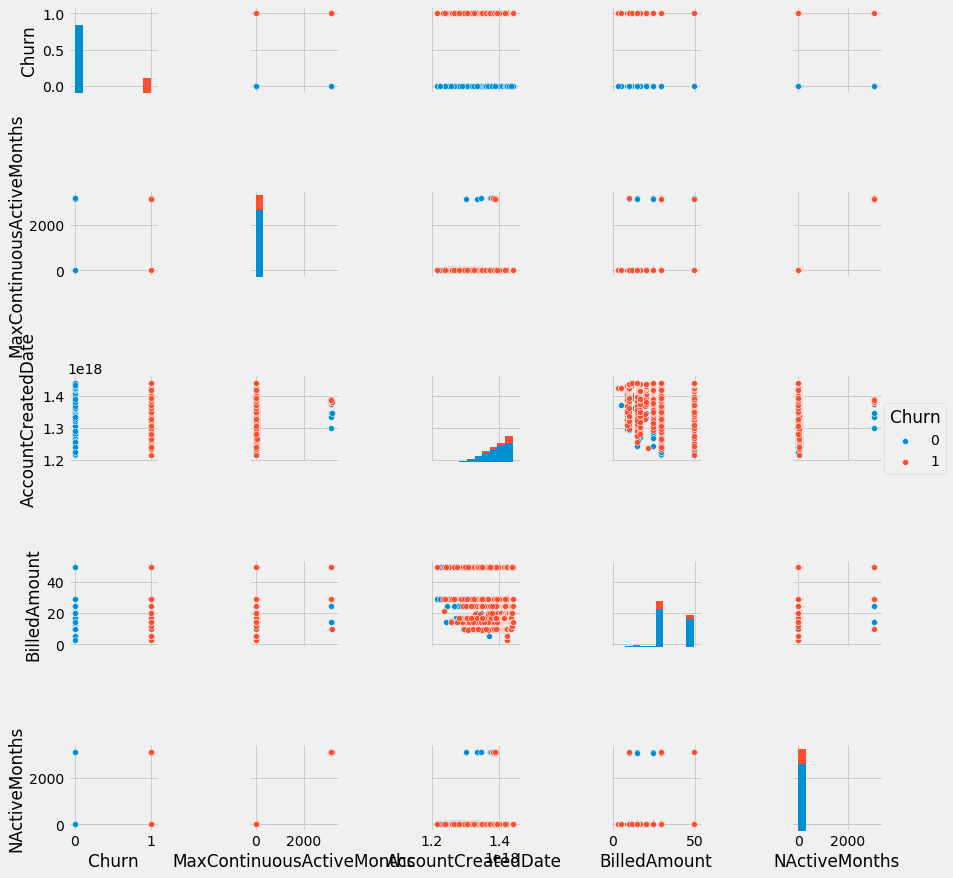

In [21]:
# Visualize feature interactions
sns.pairplot(df[['Churn','MaxContinuousActiveMonths','AccountCreatedDate','BilledAmount','NActiveMonths']], hue='Churn')# Visualize feature interactions

